 # Introduction:
 `Social Media Engagement Dataset` is focused detailed information about individual social media posts related to various brands and campaigns.



---


 This data will be used to support exploratory data analysis in the following requiremensts:
  1. Compare engagement rates across platforms and campaigns.

  2. Analyze sentiment trends by location and language.

  3. Identify top-performing campaigns and products.

  4. Train a model to predict engagement based on post content.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
import joblib



In [3]:
df = pd.read_csv("/content/drive/MyDrive/Projects/Social Media Engagement/Social Media Engagement Dataset.csv")
df.head(5)

,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,...,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
0,kcqbs6hxybia,2024-12-09 11:26:15,Monday,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Just tried the Chromebook from Google. Best pu...,#Food,NaN,...,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1
1,vkmervg4ioos,2024-07-28 19:59:26,Sunday,Twitter,user_ucryct98,"Tokyo, Japan",ru,Just saw an ad for Microsoft Surface Laptop du...,"#MustHave, #Food","@CustomerService, @BrandCEO",...,359,52764,0.05086,Microsoft,Surface Laptop,PowerRelease,Post-Launch,0.1369,-0.4510,-42.6
2,memhx4o1x6yu,2024-11-23 14:00:12,Saturday,Reddit,user_7rrev126,"Beijing, China",ru,What's your opinion about Nike's Epic React? ...,"#Promo, #Food, #Trending",NaN,...,643,8887,0.45425,Nike,Epic React,BlackFriday,Post-Launch,0.2855,-0.4112,17.4
3,bhyo6piijqt9,2024-09-16 04:35:25,Monday,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,Bummed out with my new Diet Pepsi from Pepsi! ...,"#Reviews, #Sustainable","@StyleGuide, @BrandSupport",...,743,6696,0.42293,Pepsi,Diet Pepsi,LaunchWave,Launch,-0.2094,-0.0167,-5.5
4,c9dkiomowakt,2024-09-05 21:03:01,Thursday,Twitter,user_l1vpox2k,"Berlin, Germany",hi,Just tried the Corolla from Toyota. Absolutely...,"#Health, #Travel","@BrandSupport, @InfluencerName",...,703,47315,0.08773,Toyota,Corolla,LocalTouchpoints,Launch,0.6867,0.0807,38.8


#1. Compare engagement rates across platforms or campaigns.

In [4]:
df_engrat = df[['platform', 'campaign_name', 'engagement_rate']].dropna()
platform_rates = df.groupby('platform')['engagement_rate'].mean().sort_values(ascending=False)
campaign_rates = df.groupby('campaign_name')['engagement_rate'].mean().sort_values(ascending=False)


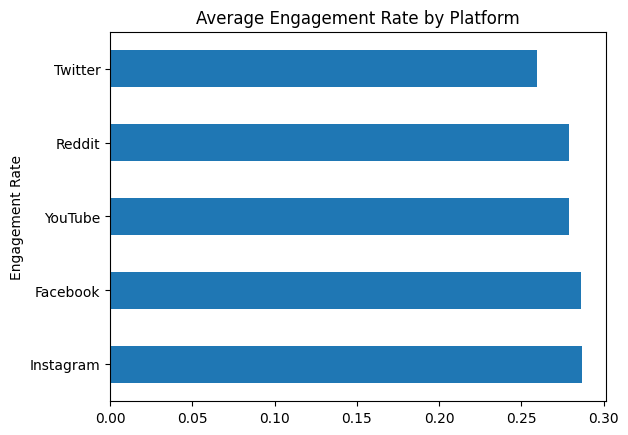

In [5]:
# Platform comparison
platform_rates.plot(kind='barh', title='Average Engagement Rate by Platform')
plt.ylabel("Engagement Rate")
plt.show()



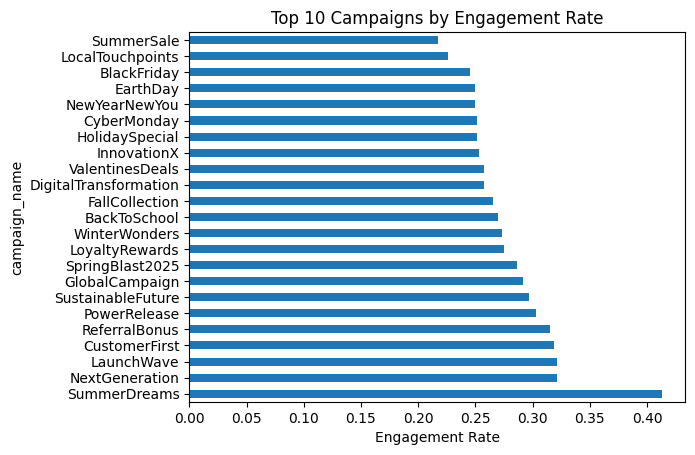

In [6]:
# Campaign comparison
campaign_rates.plot(kind='barh', title='Top 10 Campaigns by Engagement Rate')
plt.xlabel("Engagement Rate")
plt.show()

#2. Analyze sentiment trends by location and language.

In [7]:
df["language"]=df["language"].map({
    "ja": "Japanese",
    "ru": "Russian",
    "es": "Spanish",
    "ar": "Arabic",
    "zh": "Chinese",
    "fr": "French",
    "en": "English",
    "de": "German",
    "hi": "Hindi",
    "pt": "Portuguese"
})

In [8]:
df_sent = df[['location', 'language', 'sentiment_score']].dropna()
location_sentiment = df_sent.groupby('location')['sentiment_score'].mean().sort_values(ascending=False)
language_sentiment = df_sent.groupby('language')['sentiment_score'].mean().sort_values(ascending=False)


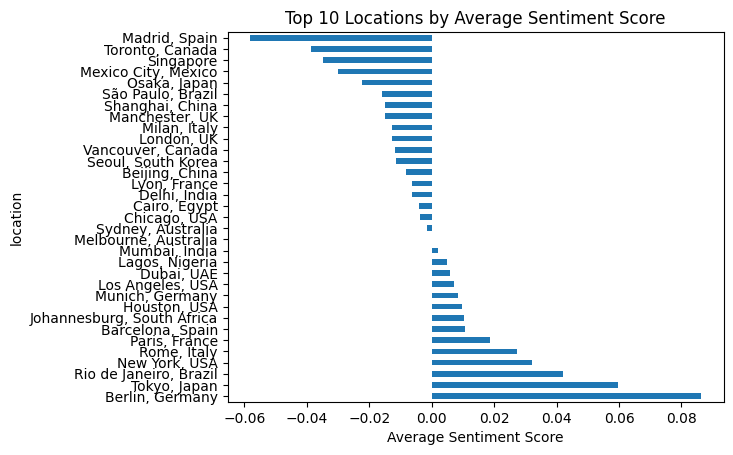

In [9]:
location_sentiment.plot(kind='barh', title='Top 10 Locations by Average Sentiment Score')
plt.xlabel('Average Sentiment Score')
plt.show()

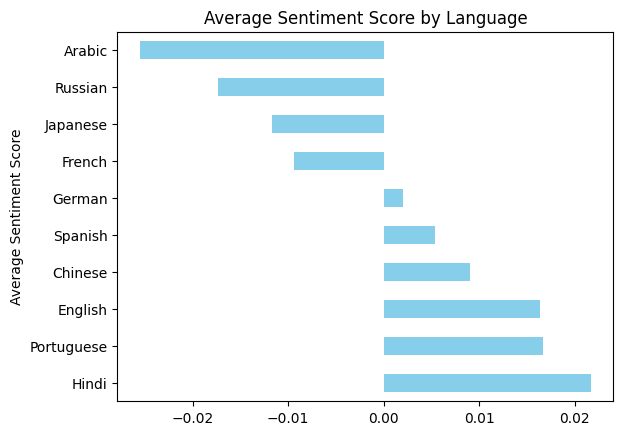

In [10]:

language_sentiment.plot(kind='barh', title='Average Sentiment Score by Language', color='skyblue')
plt.ylabel('Average Sentiment Score')
plt.show()

#3. Identify top-performing campaigns and products.

In [11]:
df_top = df[['campaign_name', 'product_name', 'engagement_rate', 'impressions']].dropna()

top_campaigns = (
    df_top.groupby('campaign_name')['engagement_rate']
    .mean()
    .sort_values(ascending=False)
)


top_products = (
    df_top.groupby('product_name')['impressions']
    .sum()
    .sort_values(ascending=False)
)


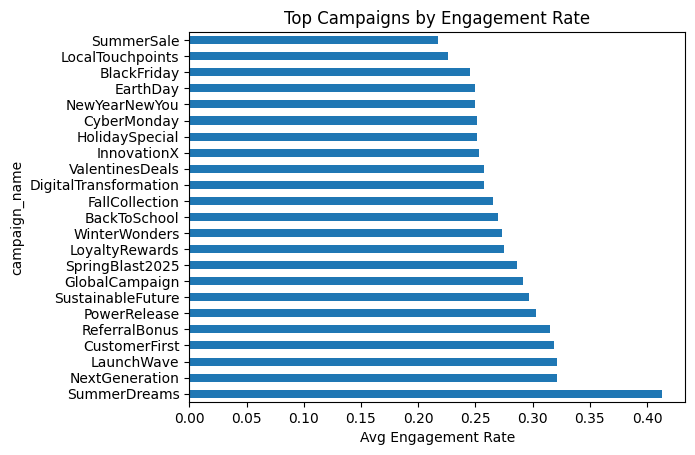

In [12]:
top_campaigns.plot(kind='barh', title='Top Campaigns by Engagement Rate')
plt.xlabel("Avg Engagement Rate")
plt.show()

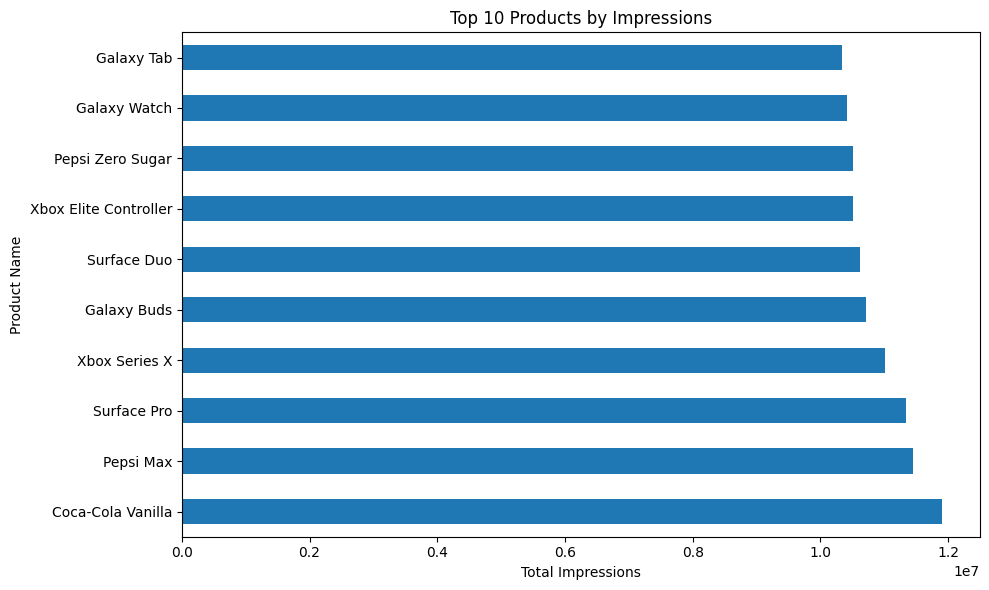

In [13]:
top_n = 10
plt.figure(figsize=(10, 6))  # Wider figure

top_products.head(top_n).plot(
    kind='barh',
    title='Top 10 Products by Impressions',
    fontsize=10,
)

plt.xlabel("Total Impressions")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()

#4. Train a model to predict engagement based on post content.

 Select and clean data

In [17]:
df_model = df[['text_content', 'engagement_rate', 'language', 'platform', 'hashtags', 'mentions']].dropna()
df_model.info()
df_model['engagement_rate'] = df_model['engagement_rate'].clip(upper=1.0)


<class 'pandas.core.frame.DataFrame'>
Index: 8059 entries, 1 to 11999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text_content     8059 non-null   object 
 1   engagement_rate  8059 non-null   float64
 2   language         8059 non-null   object 
 3   platform         8059 non-null   object 
 4   hashtags         8059 non-null   object 
 5   mentions         8059 non-null   object 
dtypes: float64(1), object(5)
memory usage: 440.7+ KB


 Feature engineering

In [18]:
quantiles = df_model['engagement_rate'].quantile([0.66])
df_model['engagement_rate'] = df_model['engagement_rate'].apply(lambda x: 'High' if x > quantiles[0.66] else 'NotHigh')

df_model['engagement_rate'].head(5)

,engagement_rate
1,NotHigh
3,High
4,NotHigh
7,NotHigh
8,NotHigh


In [21]:
df_model['hashtag_count'] = df_model['hashtags'].fillna('').apply(lambda x: len(str(x).split(',')))
df_model['mention_count'] = df_model['mentions'].fillna('').apply(lambda x: len(str(x).split(',')))
df_model['text_len'] = df_model['text_content'].str.len()
df_model['word_count'] = df_model['text_content'].str.split().apply(len)


In [22]:
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english', min_df=5)
X_text = tfidf.fit_transform(df_model['text_content'])

In [23]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_cat = ohe.fit_transform(df_model[['platform', 'language']])

In [24]:
X_dense = df_model[['hashtag_count', 'mention_count', 'text_len', 'word_count']].values


In [29]:
X = hstack([X_text, csr_matrix(X_cat), csr_matrix(X_dense)])


In [31]:
le = LabelEncoder()
y = df_model['engagement_rate']
y_encoded = le.fit_transform(y)

In [32]:
X_train, X_test, y_train_text, y_test_text = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 152218 stored elements and shape (6447, 1017)>

Train, predict, and evaluate

In [33]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

In [34]:
for name, model in models.items():
    print(f"\n🔍 Training: {name}")

    if name == 'XGBoost':
        model.fit(X_train_enc, y_train_enc)
        y_pred_enc = model.predict(X_test_enc)
        y_pred = le.inverse_transform(y_pred_enc)
        y_true = le.inverse_transform(y_test_enc)
    else:
        model.fit(X_train, y_train_text)

        y_pred = model.predict(X_test)
        y_true = y_test_text

    print(f"📊 Evaluation Report: {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))


🔍 Training: Random Forest
📊 Evaluation Report: Random Forest
Accuracy: 0.6308933002481389
              precision    recall  f1-score   support

        High       0.35      0.10      0.16       548
     NotHigh       0.66      0.90      0.76      1064

    accuracy                           0.63      1612
   macro avg       0.51      0.50      0.46      1612
weighted avg       0.56      0.63      0.56      1612


🔍 Training: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📊 Evaluation Report: Logistic Regression
Accuracy: 0.6482630272952854
              precision    recall  f1-score   support

        High       0.28      0.02      0.04       548
     NotHigh       0.66      0.97      0.78      1064

    accuracy                           0.65      1612
   macro avg       0.47      0.50      0.41      1612
weighted avg       0.53      0.65      0.53      1612


🔍 Training: XGBoost
📊 Evaluation Report: XGBoost
Accuracy: 0.6191066997518611
              precision    recall  f1-score   support

        High       0.32      0.10      0.16       548
     NotHigh       0.66      0.88      0.75      1064

    accuracy                           0.62      1612
   macro avg       0.49      0.49      0.46      1612
weighted avg       0.54      0.62      0.55      1612



In [35]:
artifact_bundle = {
    'tfidf': tfidf,
    'onehot': ohe,
    'label_encoder': le,
    'quantile_threshold': quantiles[0.66],
    'Random Forest': models['Random Forest'],
    'Logistic Regression': models['Logistic Regression'],
    'XGBoost': models['XGBoost']
}
model_path="/content/drive/MyDrive/Projects/Social Media Engagement/engagement_model_bundle.pkl"
joblib.dump(artifact_bundle, model_path)



['/content/drive/MyDrive/Projects/Social Media Engagement/engagement_model_bundle.pkl']